In [2]:
import pandas as pd
import numpy as np
import calendar
from time import strptime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
main_bookings_df = pd.read_csv('hotel_bookings.csv')
len(main_bookings_df)

119390

In [4]:
missing_values = pd.DataFrame(main_bookings_df.isna().sum())
print(main_bookings_df.columns)
missing_values[missing_values[0]>0]

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')


,0
children,4
country,488
agent,16340
company,112593


In [5]:
# to get a rough estimate of room bookings, im going to assume there are only triple rooms and adults+children (not babies) are considered for total people
approx_bookings = lambda total_people: total_people//3+ (0 if total_people%3==0 else 1)

analysis_cpy_df = main_bookings_df.copy()
analysis_cpy_df['arrival_date'] = pd.to_datetime(analysis_cpy_df.apply(lambda x:f"{x.arrival_date_year}-{strptime(x.arrival_date_month,'%B').tm_mon:02}-{x.arrival_date_day_of_month}", axis=1))
analysis_cpy_df['bookings'] = analysis_cpy_df.apply(lambda x: approx_bookings(x.adults+x.children), axis=1)
analysis_cpy_df['booking_date'] = analysis_cpy_df['arrival_date']- pd.to_timedelta(analysis_cpy_df['lead_time'], unit='days')
analysis_cpy_df['reservation_status_date_check'] = pd.to_datetime(analysis_cpy_df['arrival_date'])+pd.to_timedelta(analysis_cpy_df['stays_in_weekend_nights']+analysis_cpy_df['stays_in_week_nights'], unit='days')

In [72]:
needed_columns = ['hotel', 'arrival_date','booking_date', 'adr', 'bookings', 'revenue']

#    CONDITIONS
# filter rows where adults==0
# filter out cancellations, for simplicity
# check missing values after filtering out cancellations
#  -there arent any missing values in the critical columns
# check the date continuity considering max and min arrival dates hotelwise


# dropping rows where adults==0 and bookings are cancelled
final_df = analysis_cpy_df[(analysis_cpy_df.is_canceled==0)&(analysis_cpy_df.adults>0)]

# getting revenue based on approx bookings
final_df['revenue'] = final_df['adr']*final_df['bookings'] 
# summing rows as per the group
final_df = final_df[needed_columns].groupby(['hotel','arrival_date','booking_date']).sum().reset_index()

# recalculating booking lead
final_df['booking_lead'] = (final_df['arrival_date']-final_df['booking_date']).dt.days
final_df = final_df.sort_values(['arrival_date','booking_date','booking_lead'])

print(final_df.columns)
print(final_df.hotel.unique())

for h_type in final_df.hotel.unique():
    print(h_type)
    min_arrival_dt = final_df[final_df.hotel==h_type].arrival_date.min()
    max_arrival_dt = final_df[final_df.hotel==h_type].arrival_date.max()
    print('\tactual num of records:', len(final_df['arrival_date'][final_df.hotel==h_type].drop_duplicates()))
    print('\tneeded num of records:', len(pd.date_range(start=min_arrival_dt, end=max_arrival_dt, freq='1D')))

# considering only resort hotel since it has all the data between min and max arrival dates
final_df = final_df[final_df.hotel=='Resort Hotel'].drop('hotel',axis=1).reset_index(drop=True)

Index(['hotel', 'arrival_date', 'booking_date', 'adr', 'bookings', 'revenue',
       'booking_lead'],
      dtype='object')
['Resort Hotel' 'City Hotel']
Resort Hotel
	actual num of records: 793
	needed num of records: 793
City Hotel
	actual num of records: 788
	needed num of records: 793


C:\Users\sanja\AppData\Local\Temp\ipykernel_19064\4134063561.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['revenue'] = final_df['adr']*final_df['bookings']


In [73]:
def cumulative_sum_by_arrival_date(group:pd.DataFrame,cumu_sum_cols:list, sorting_cols:list = ['booking_date']) -> pd.DataFrame:
    group = group.sort_values(sorting_cols)

    for col in cumu_sum_cols:
        group[f'cumu_{col}'] = group[col].cumsum()
    return group

#considering the cumulative sums
final_df = final_df.groupby(['arrival_date']).apply(lambda x: cumulative_sum_by_arrival_date(x,cumu_sum_cols=['adr', 'bookings', 'revenue'])).reset_index(drop=True)


C:\Users\sanja\AppData\Local\Temp\ipykernel_19064\2177140345.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = final_df.groupby(['arrival_date']).apply(lambda x: cumulative_sum_by_arrival_date(x,cumu_sum_cols=['adr', 'bookings', 'revenue'])).reset_index(drop=True)


In [205]:
max_booking_lead = final_df[['arrival_date','booking_lead']].groupby('arrival_date').max().rename(columns = {'booking_lead':'max_booking_lead'}).reset_index()
min_booking_lead = final_df[['arrival_date','booking_lead']].groupby('arrival_date').min().rename(columns = {'booking_lead':'min_booking_lead'}).reset_index()
min_max_booking_lead = max_booking_lead.merge(min_booking_lead, on='arrival_date',how='inner')
min_max_booking_lead['filled_booking_leads'] = min_max_booking_lead.apply(lambda x: np.arange(x.min_booking_lead, x.max_booking_lead +1), axis=1)

booking_leads_filled = min_max_booking_lead.explode('filled_booking_leads').drop(['max_booking_lead', 'min_booking_lead'], axis=1).rename(columns={'filled_booking_leads':'booking_lead'})
preprocess_df = booking_leads_filled.merge(final_df.drop(['booking_date','adr','bookings','revenue'] ,axis=1), on=['arrival_date','booking_lead'], how='left')

# forward fill any missing values in between the max and min leads of a given stay date, ffill is used since we can only fill the missing values with past values since this is time-series.
preprocess_df = preprocess_df.groupby('arrival_date').apply(lambda x: x.sort_values('booking_lead',ascending=False).ffill()).reset_index(drop=True)


# trimming the lead to the number of needed booking leads
needed_booking_lags = 100

needed_booking_lead = final_df[['arrival_date']].drop_duplicates()
needed_booking_lead['booking_lead'] = [np.arange(0,needed_booking_lags+1)]*len(needed_booking_lead)
needed_booking_lead=needed_booking_lead.explode('booking_lead')

preprocess_df = needed_booking_lead.merge(preprocess_df, on=['arrival_date','booking_lead'], how='outer')
preprocess_df = preprocess_df.groupby('arrival_date').apply(lambda x : x.sort_values('booking_lead', ascending=False).ffill()).reset_index(drop=True).fillna(0)
preprocess_df = preprocess_df[preprocess_df.booking_lead<=needed_booking_lags]
preprocess_df['booking_date'] = preprocess_df['arrival_date'] - pd.to_timedelta(preprocess_df['booking_lead'], unit='days')


target_type_col = 'cumu_revenue'
target_prefix = 'RV'

preprocess_df['target'] = target_prefix+ preprocess_df['booking_lead'].astype('str')

final_df_2 = preprocess_df.pivot(index=['arrival_date'],columns='target', values=target_type_col).reset_index()
final_df_2 = final_df_2.reindex(['arrival_date']+sorted(final_df_2.drop('arrival_date',axis=1).columns, key=lambda x: int(x[2:])), axis=1) 


C:\Users\sanja\AppData\Local\Temp\ipykernel_19064\3799056695.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  preprocess_df = preprocess_df.groupby('arrival_date').apply(lambda x: x.sort_values('booking_lead',ascending=False).ffill()).reset_index(drop=True)
C:\Users\sanja\AppData\Local\Temp\ipykernel_19064\3799056695.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  preprocess_df = preprocess_df.groupby('arrival_date').apply(lambda x: x.sort_values('booking_lead',ascending=

In [179]:
# # inspecting the data preprocessing step
# check_lead_fill = preprocess_df[(preprocess_df.cumu_adr.isna())][['arrival_date','booking_lead']]
# check_lead_fill_max = check_lead_fill.groupby('arrival_date').max().rename(columns = {'booking_lead':'max_booking_lead_na'}).reset_index()
# check_lead_fill_min = check_lead_fill.groupby('arrival_date').min().rename(columns = {'booking_lead':'min_booking_lead_na'}).reset_index()
# check_lead_fill = check_lead_fill_max.merge(check_lead_fill_min, on='arrival_date', how='inner')
# check_lead_fill = min_max_booking_lead.drop('filled_booking_leads',axis=1).merge(check_lead_fill, on='arrival_date', how='inner')

# check_lead_fill[check_lead_fill['max_booking_lead']<check_lead_fill['max_booking_lead_na']]


,arrival_date,max_booking_lead,min_booking_lead,max_booking_lead_na,min_booking_lead_na
0,2015-07-15,83,0,100,84
1,2015-07-22,84,0,100,85
2,2015-10-26,60,0,100,61
3,2015-10-27,61,0,100,62
4,2015-10-28,49,0,100,50
...,...,...,...,...,...
68,2017-01-20,27,0,100,28
69,2017-01-27,46,0,100,47
70,2017-02-01,34,0,100,35
71,2017-02-07,87,0,100,88


<Axes: xlabel='arrival_date', ylabel='revenue'>

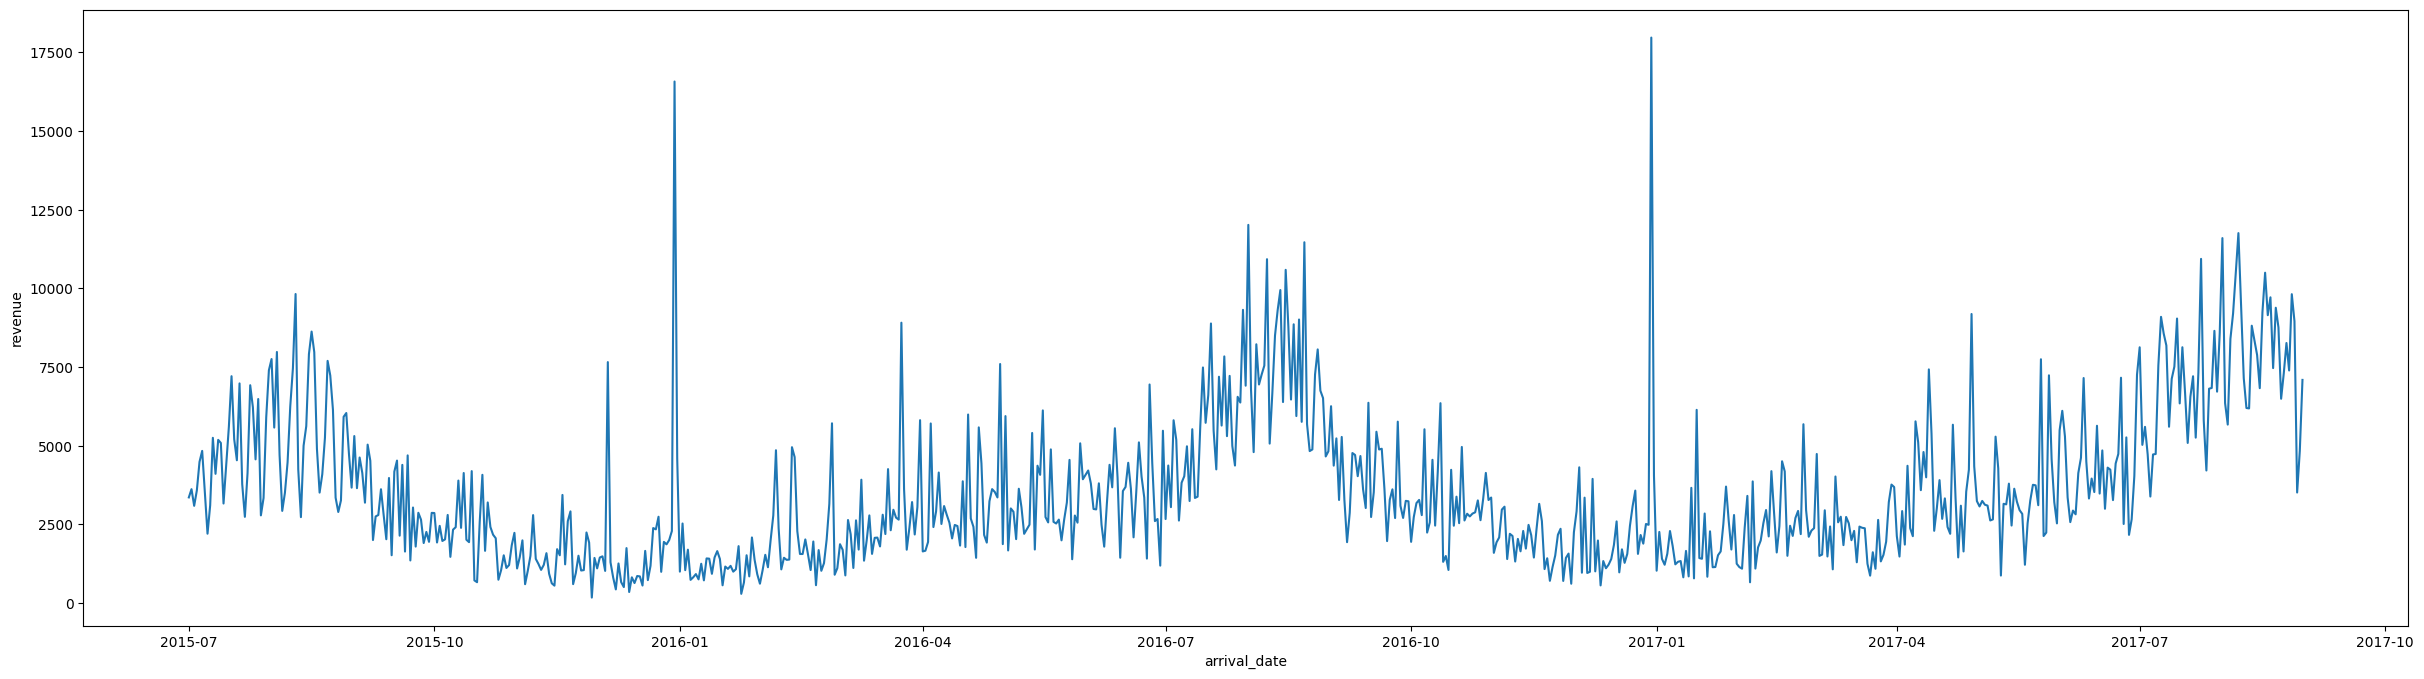

In [8]:
plt.figure(figsize=(30,8))
sns.lineplot(data=final_df,x='arrival_date', y='revenue')

In [9]:
print('train start date:', final_df.arrival_date.min())
print('train end date:', final_df.arrival_date.max()-pd.to_timedelta(365,unit='days'))
print('number of training days :',((final_df.arrival_date.max()-pd.to_timedelta(365,unit='days')) - final_df.arrival_date.min()).days)


train start date: 2015-07-01 00:00:00
train end date: 2016-08-31 00:00:00
number of training days : 427


In [10]:
final_df

,arrival_date,adr,bookings,revenue
0,2015-07-01,3356.83,38.0,3356.83
1,2015-07-02,3512.12,36.0,3619.12
2,2015-07-03,2937.12,28.0,3090.12
3,2015-07-04,3415.44,38.0,3578.44
4,2015-07-05,3994.76,40.0,4486.96
...,...,...,...,...
788,2017-08-27,8271.30,51.0,9816.47
789,2017-08-28,7972.97,45.0,8957.56
790,2017-08-29,3512.50,21.0,3512.50
791,2017-08-30,4404.57,30.0,4837.43


In [206]:
train_start_dt: pd.Timestamp = pd.to_datetime('2015-07-01')
train_end_dt:pd.Timestamp = pd.to_datetime('2016-08-31')
col_to_predict = 'revenue'
input_n_lags = 60

training_df = final_df_2[(final_df_2.arrival_date>=train_start_dt)&(final_df_2.arrival_date<=train_end_dt)].copy()
training_df.to_csv('train_df_2.csv')


In [31]:
# training_df.to_csv('train_df.csv')

In [207]:
# test_df = final_df_2[final_df_2.arrival_date>train_end_dt].copy()
# test_df.to_csv('test_df_2.csv')

In [33]:
# test_df.to_csv('test_df.csv')

In [28]:
final_df

,arrival_date,adr,bookings,revenue
0,2015-07-01,3356.83,38.0,3356.83
1,2015-07-02,3512.12,36.0,3619.12
2,2015-07-03,2937.12,28.0,3090.12
3,2015-07-04,3415.44,38.0,3578.44
4,2015-07-05,3994.76,40.0,4486.96
...,...,...,...,...
788,2017-08-27,8271.30,51.0,9816.47
789,2017-08-28,7972.97,45.0,8957.56
790,2017-08-29,3512.50,21.0,3512.50
791,2017-08-30,4404.57,30.0,4837.43


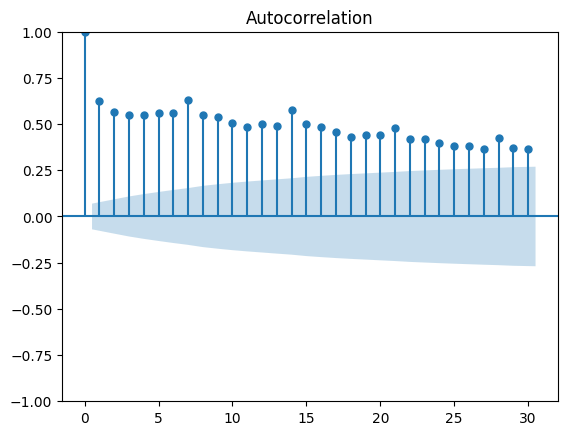

In [25]:
sm.graphics.tsa.plot_acf(final_df['revenue'], lags=30)
plt.show()